<h1>Analysis of Tumor Exome Mutations</h1>

<h2>Author: Yogindra Raghav</h2>
<h2>Email: yraghav97@gmail.com</h2>

<!--[cancer_cells](https://swami.wustl.edu/wp-content/uploads/2015/07/cancers-cells-1038x576.jpg)-->
<img src="https://swami.wustl.edu/wp-content/uploads/2015/07/cancers-cells-1038x576.jpg" alt="cancer cells" width="600px">

In [1]:
import pandas
import itertools 
import collections
import matplotlib.pyplot as plt
import fisher 

<h3>Load All DataFrames into Dict</h3>

In [2]:
# dict for all MAF data 
all_mafs = {}

# for all 50 MAF files 
for i in range(0,50): 
    # load all MAF data into dict using patient number as key 
    all_mafs["Patient-"+str(i)] = pandas.read_csv("mafs/Patient-"+str(i)+".somatic.snvs.maf", sep="\t")
    

<h3>Subset for: NOT Variant Classification "Silent"</h3>

In [3]:
# dict for dataframes subsetted for non-silent variants 
not_silent = {} 

# for all MAFs
for maf in all_mafs: 
    # subset for variants that are not "silent" variants 
    not_silent[maf] = all_mafs[maf].loc[all_mafs[maf]["Variant_Classification"]!="Silent"]

not_silent["Patient-0"].head()

,Hugo_Symbol,Chromosome,Start_position,End_position,Variant_Classification,Variant_Type,Reference_Allele,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Protein_Change,t_alt_count,t_ref_count
0,AMOT,X,112035152,112035152,Missense_Mutation,SNP,G,G,C,Patient-0-Tumor,Patient-0-Normal,p.Q612E,8,31
1,SEMA6D,15,48062786,48062786,Missense_Mutation,SNP,G,G,A,Patient-0-Tumor,Patient-0-Normal,p.A676T,4,87
2,PRR12,19,50100969,50100969,Missense_Mutation,SNP,C,C,G,Patient-0-Tumor,Patient-0-Normal,p.S1126C,5,25
7,ZNF253,19,20002885,20002885,Missense_Mutation,SNP,G,G,A,Patient-0-Tumor,Patient-0-Normal,p.V277I,6,66
8,MEF2C,5,88025061,88025061,Missense_Mutation,SNP,G,G,A,Patient-0-Tumor,Patient-0-Normal,p.S313L,6,42


<h3>Create Histogram of 10 Most Common Mutations</h3>

**Populate Dict to Build Histogram**

In [4]:
# dict for plotting histogram 
histogram_plot_dict = {} 

# for each dataframe 
for dataframe in not_silent: 
    # get list of hugo symbols from dataframe
    hugo_genes = not_silent[dataframe]["Hugo_Symbol"].tolist()
    
    # update histogram dict for future plotting 
    for gene in hugo_genes:
        if gene in histogram_plot_dict: 
            histogram_plot_dict[gene] +=1
        else: 
            histogram_plot_dict[gene] = 1

**Pull 10 Highest Counts' Genes**

In [5]:
# sort dict by values (highest to lowest) 
histogram_plot_dict={k: v for k, v in sorted(histogram_plot_dict.items(), key=lambda item: item[1], reverse=True)}

# pull first 10 times and coerce to dict for future plotting 
histogram_plot_dict = dict(itertools.islice(histogram_plot_dict.items(), 0,10))

# print dict clean 
for gene in histogram_plot_dict: 
    print(gene+"\t"+str(histogram_plot_dict[gene]))

TTN	41
TP53	30
ERBB4	27
MUC16	22
SPEN	22
KMT2C	20
KMT2D	17
ERBB3	16
FRG1B	14
ZNF91	13



**Create Figure**

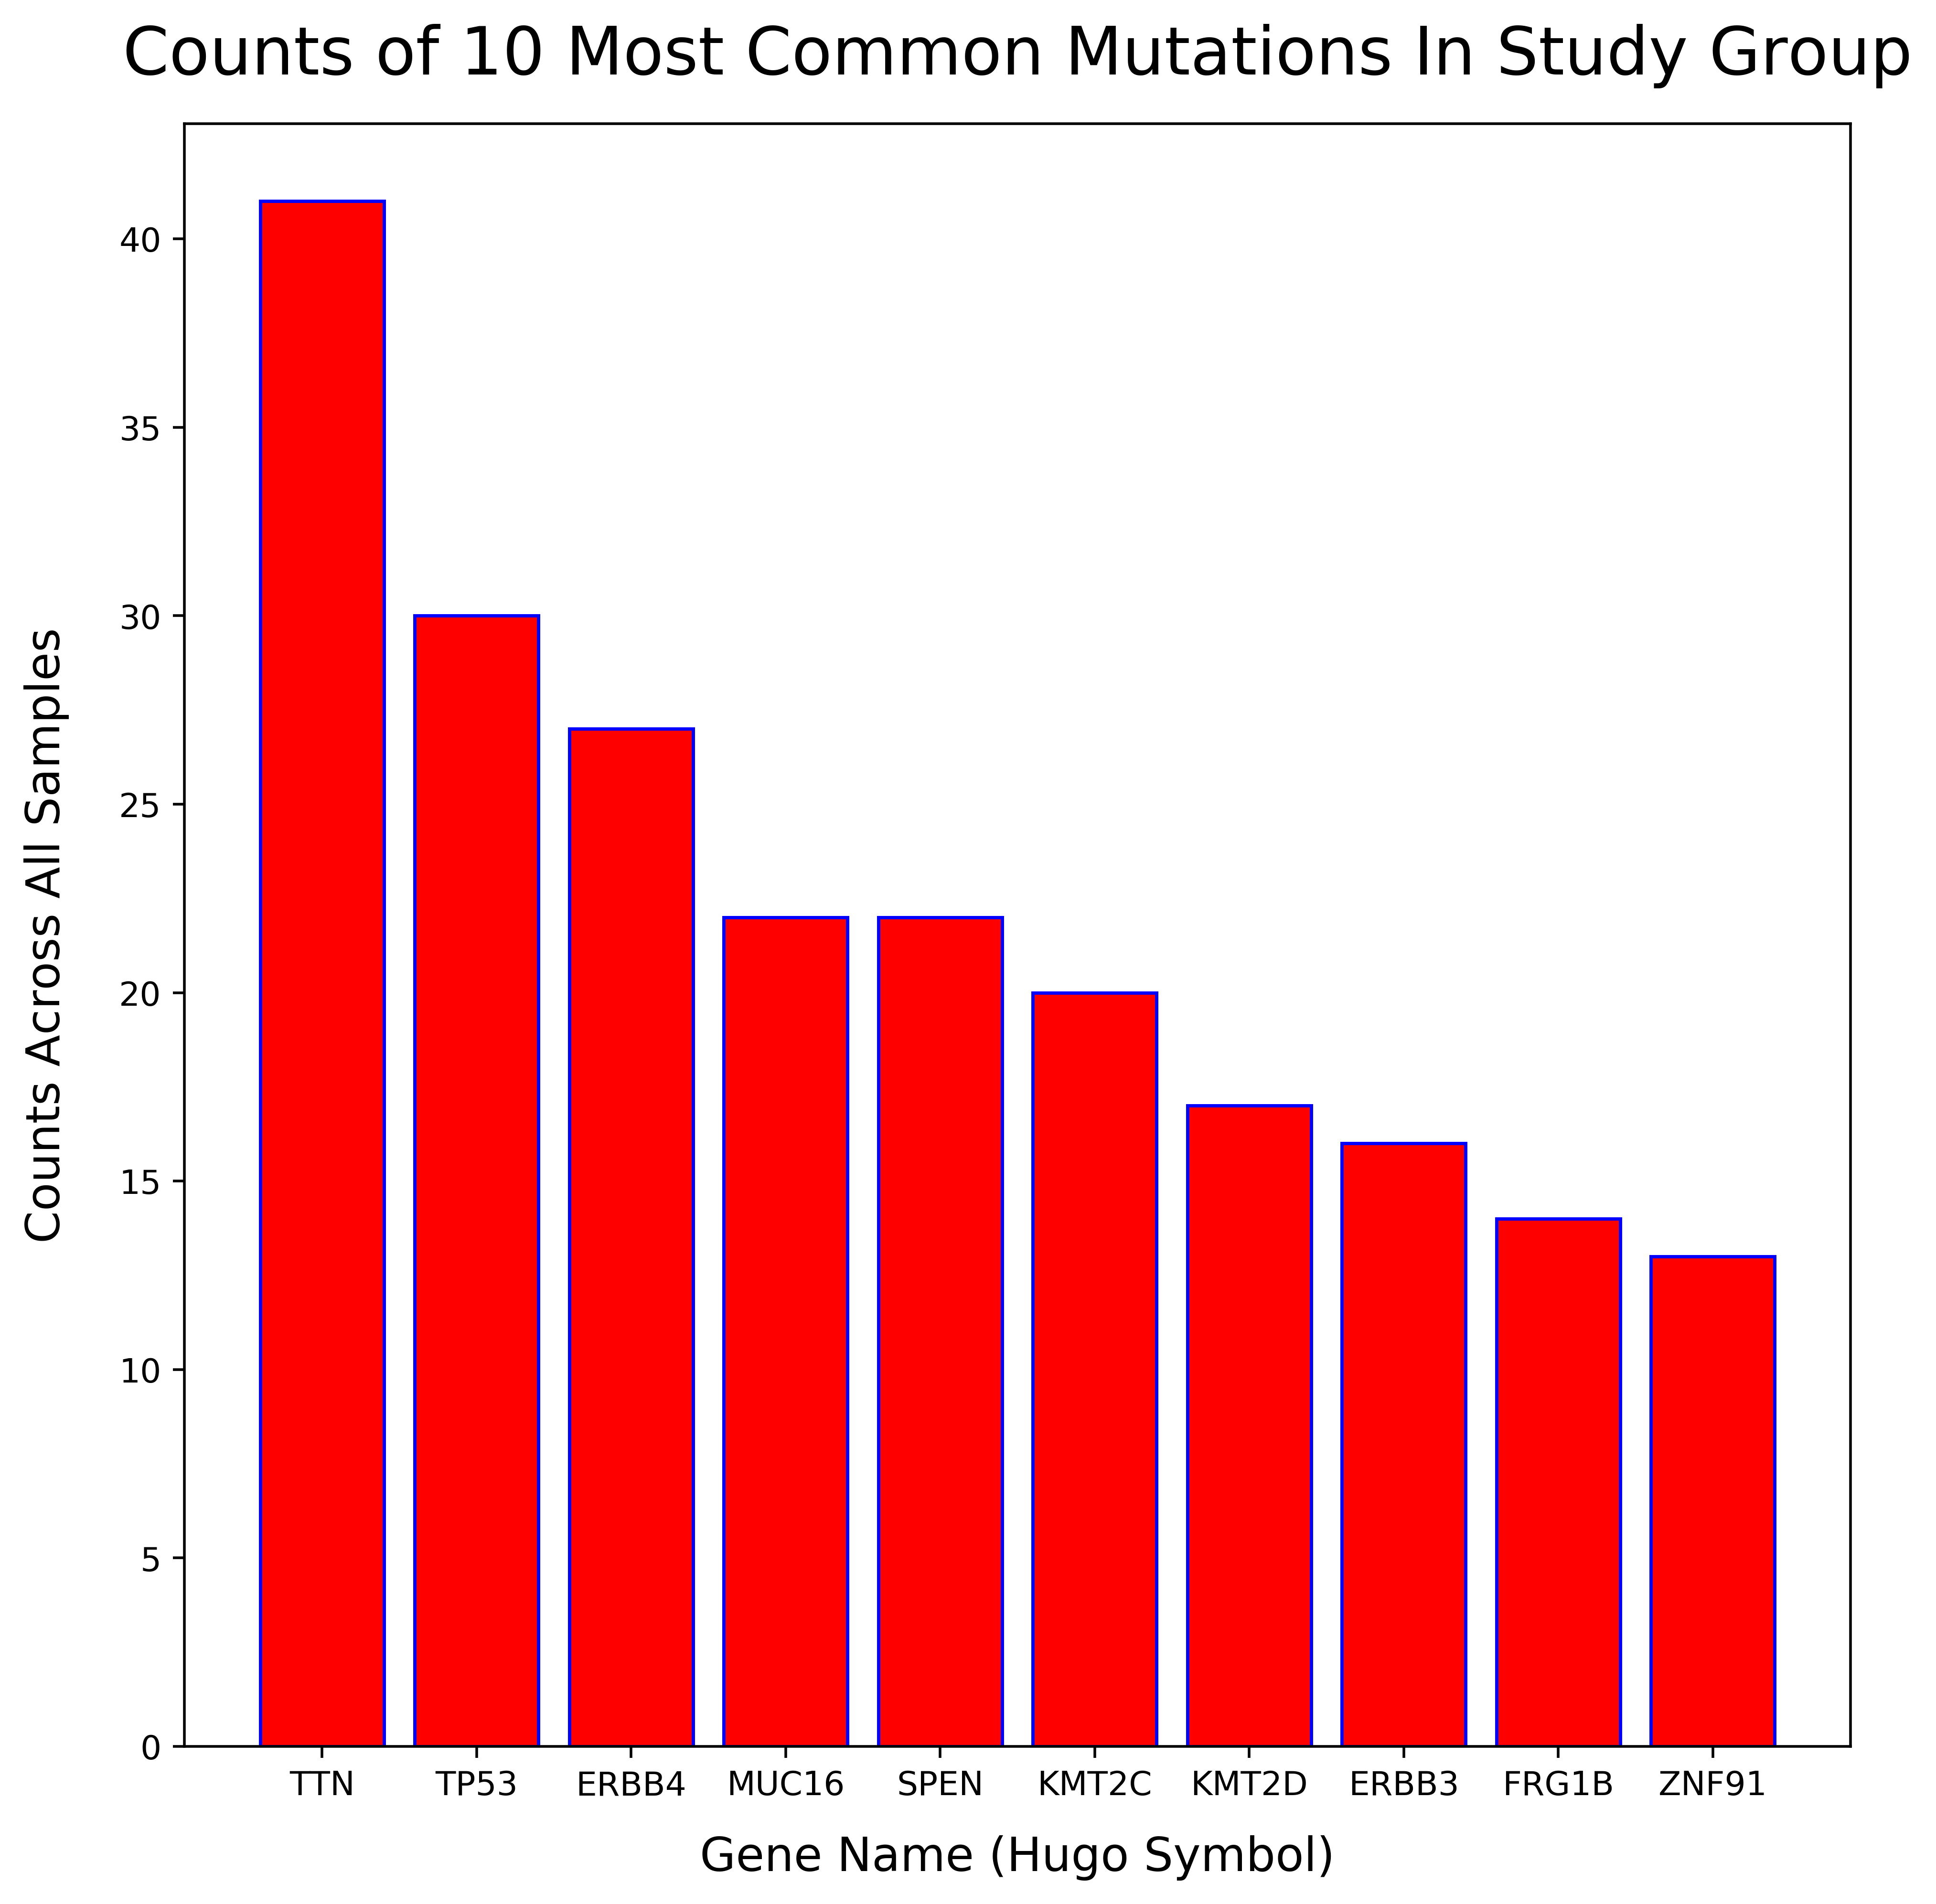

In [6]:
# adjust figure size and quality 
plt.figure(figsize=(9,9), dpi = 500)

# make bar plot 
plt.bar(histogram_plot_dict.keys(), histogram_plot_dict.values(), color="red", edgecolor="blue")

# update y label 
plt.ylabel("Counts Across All Samples", labelpad=15, size=14)
# update x label 
plt.xlabel("Gene Name (Hugo Symbol)", labelpad=10, size=14)
# update title 
plt.title("Counts of 10 Most Common Mutations In Study Group", size=20, pad=15)

#show plot
plt.show()

<h3>Are Any Mutated Genes Significantly Enriched in Patients who Responded or Not?</h3>

**Load Patient Metadata** 

In [7]:
# read tsv and use patient ID as index 
patient_metadata = pandas.read_csv("./sample-information.tsv", sep="\t", index_col=0)
patient_metadata.head()

,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Response,Silent_mutations_per_Mb,Nonsynonymous_mutations_per_Mb,Mutations_per_Mb
Patient_ID,,,,,,
Patient-0,Patient-0-Tumor,Patient-0-Normal,Non-Responder,2.87,6.77,9.64
Patient-1,Patient-1-Tumor,Patient-1-Normal,Responder,1.92,6.14,8.06
Patient-2,Patient-2-Tumor,Patient-2-Normal,Responder,1.32,2.84,4.16
Patient-3,Patient-3-Tumor,Patient-3-Normal,Non-Responder,1.78,5.00,6.78
Patient-4,Patient-4-Tumor,Patient-4-Normal,Responder,4.93,10.50,15.43


**Find All Unique Genes (Hugo Symbols)**

In [8]:
# list of all unique genes 
hugo_symbols = []

# for each dataframe 
for dataframe in not_silent: 
    # get list of hugo symbols from dataframe
    hugo_symbols.extend(not_silent[dataframe]["Hugo_Symbol"].tolist())

# de-dupe the list
hugo_symbols = list(set(hugo_symbols))
len(hugo_symbols)

6927

**Calculate Contingency Tables for Each Gene**

In [9]:
# create dict indexed by gene containing each contingency table
contingency_tables = {}

# for each gene (hugo symbol) 
for gene in hugo_symbols: 
    """
    CONTINGENCY TABLE VARIABLES
    """
    # had mutation and responded 
    mutation_responded = 0 
    # no mutation and responded 
    no_mutation_responded = 0
    # mutation and didn't respond  
    mutation_not_responded =0 
    # no mutation and not responded 
    no_mutation_not_responded =0 
    """
    END
    """
    
    # for each dataframe (each named after patient ID) 
    for dataframe in not_silent:
        # get responder status (i.e. responder to drug or did not respond) 
        response_status = patient_metadata.at[dataframe, "Response"]
        # find out if patient has mutation or not 
        has_mutation = not_silent[dataframe]["Hugo_Symbol"].str.contains(gene).any()
        
        # mutation and responded 
        if has_mutation and response_status == "Responder": 
            mutation_responded+=1 
        # no mutation and responded 
        elif not has_mutation and response_status == "Responder": 
            no_mutation_responded+=1
        # mutation and didn't respond 
        elif has_mutation and response_status=="Non-Responder": 
            mutation_not_responded+=1 
        # no mutation and didn't respond 
        elif not has_mutation and response_status=="Non-Responder": 
            no_mutation_not_responded+=1
    
    # add contingency table to dict 
    contingency_tables[gene] = [mutation_responded, no_mutation_responded,mutation_not_responded, no_mutation_not_responded]


**Calculate P-Values Using Fisher's Exact Test**

In [10]:
# let user know that significant genes are being printed out
print("SIGNIFICANT MUTATED GENES:")

# dict of significant genes 
sig_genes = {}
# dict of non-significant genes 
non_sig_genes = {}

# for each gene 
for gene in contingency_tables: 
    # get list of contingency table values 
    contingency_table_values = contingency_tables[gene]
    
    # calculate p values using fisher's exact test 
    p = fisher.pvalue(contingency_table_values[0],contingency_table_values[1],contingency_table_values[2],contingency_table_values[3])
    
    # if two-tail test p value is less than 0.05 (i.e. significant)
    if p.two_tail <=0.05: 
        # append to significant genes dict 
        sig_genes[gene]=p.two_tail
        # identify which genes and associated information are "significant" 
        print(gene+"\t"+ str(contingency_tables[gene])+"\t"+str(p))
    # two-tail test p value is non-significant (>0.05) 
    else: 
        # append to non-significant genes dict 
        non_sig_genes[gene]=p.two_tail 


SIGNIFICANT MUTATED GENES:
AKAP1	[7, 18, 0, 25]	PValues(left_tail=1, right_tail=0.004813, two_tail=0.009625)
ERC1	[7, 18, 0, 25]	PValues(left_tail=1, right_tail=0.004813, two_tail=0.009625)
AHNAK	[9, 16, 2, 23]	PValues(left_tail=0.9977, right_tail=0.01871, two_tail=0.03743)
ERCC2	[9, 16, 0, 25]	PValues(left_tail=1, right_tail=0.0008154, two_tail=0.001631)
HECTD1	[6, 19, 0, 25]	PValues(left_tail=1, right_tail=0.01114, two_tail=0.02229)
SI	[17, 8, 9, 16]	PValues(left_tail=0.9949, right_tail=0.02324, two_tail=0.04648)
TTL	[14, 11, 5, 20]	PValues(left_tail=0.9985, right_tail=0.009314, two_tail=0.01863)
MACF1	[6, 19, 0, 25]	PValues(left_tail=1, right_tail=0.01114, two_tail=0.02229)
RCC2	[10, 15, 1, 24]	PValues(left_tail=0.9999, right_tail=0.002307, two_tail=0.004614)
AKAP9	[6, 19, 0, 25]	PValues(left_tail=1, right_tail=0.01114, two_tail=0.02229)
KMT2C	[7, 18, 1, 24]	PValues(left_tail=0.998, right_tail=0.0244, two_tail=0.0488)
HERC1	[6, 19, 0, 25]	PValues(left_tail=1, right_tail=0.01114, two

<h3>Scatter Plot of Mutated Patients vs. Significant Mutations</h3>

**Prepare Lists for Creating Scatter Plots** 

In [11]:
# list for number of patients with mutation for non-significant genes 
num_mutations_non_sig = [] 
# list of two-tail p-values for non-significant genes 
non_sig_p_values = [] 
# list of non-sig gene names 
non_sig_gene_names = [] 

# for each non-significant gene 
for gene in non_sig_genes: 
    # get number of patients with non-significant gene mutation
    num_mutations_non_sig.append(contingency_tables[gene][0]+contingency_tables[gene][2])
    # get two tail p-values for non-significant gene mutations 
    non_sig_p_values.append(non_sig_genes[gene])
    # add gene name to list 
    non_sig_gene_names.append(gene)


In [12]:
# list for number of patients with mutation for significant genes 
num_mutations_sig = [] 
# list of two-tail p-values for significant genes 
sig_p_values = [] 
# list of sig gene names 
sig_gene_names = [] 

# for each significant gene 
for gene in sig_genes: 
    # get number of patients with significant gene mutation
    num_mutations_sig.append(contingency_tables[gene][0]+contingency_tables[gene][2])
    # get two tail p-values for significant gene mutations 
    sig_p_values.append(sig_genes[gene])
    # add gene name to list 
    sig_gene_names.append(gene)
    

**Create Scatterplot** 

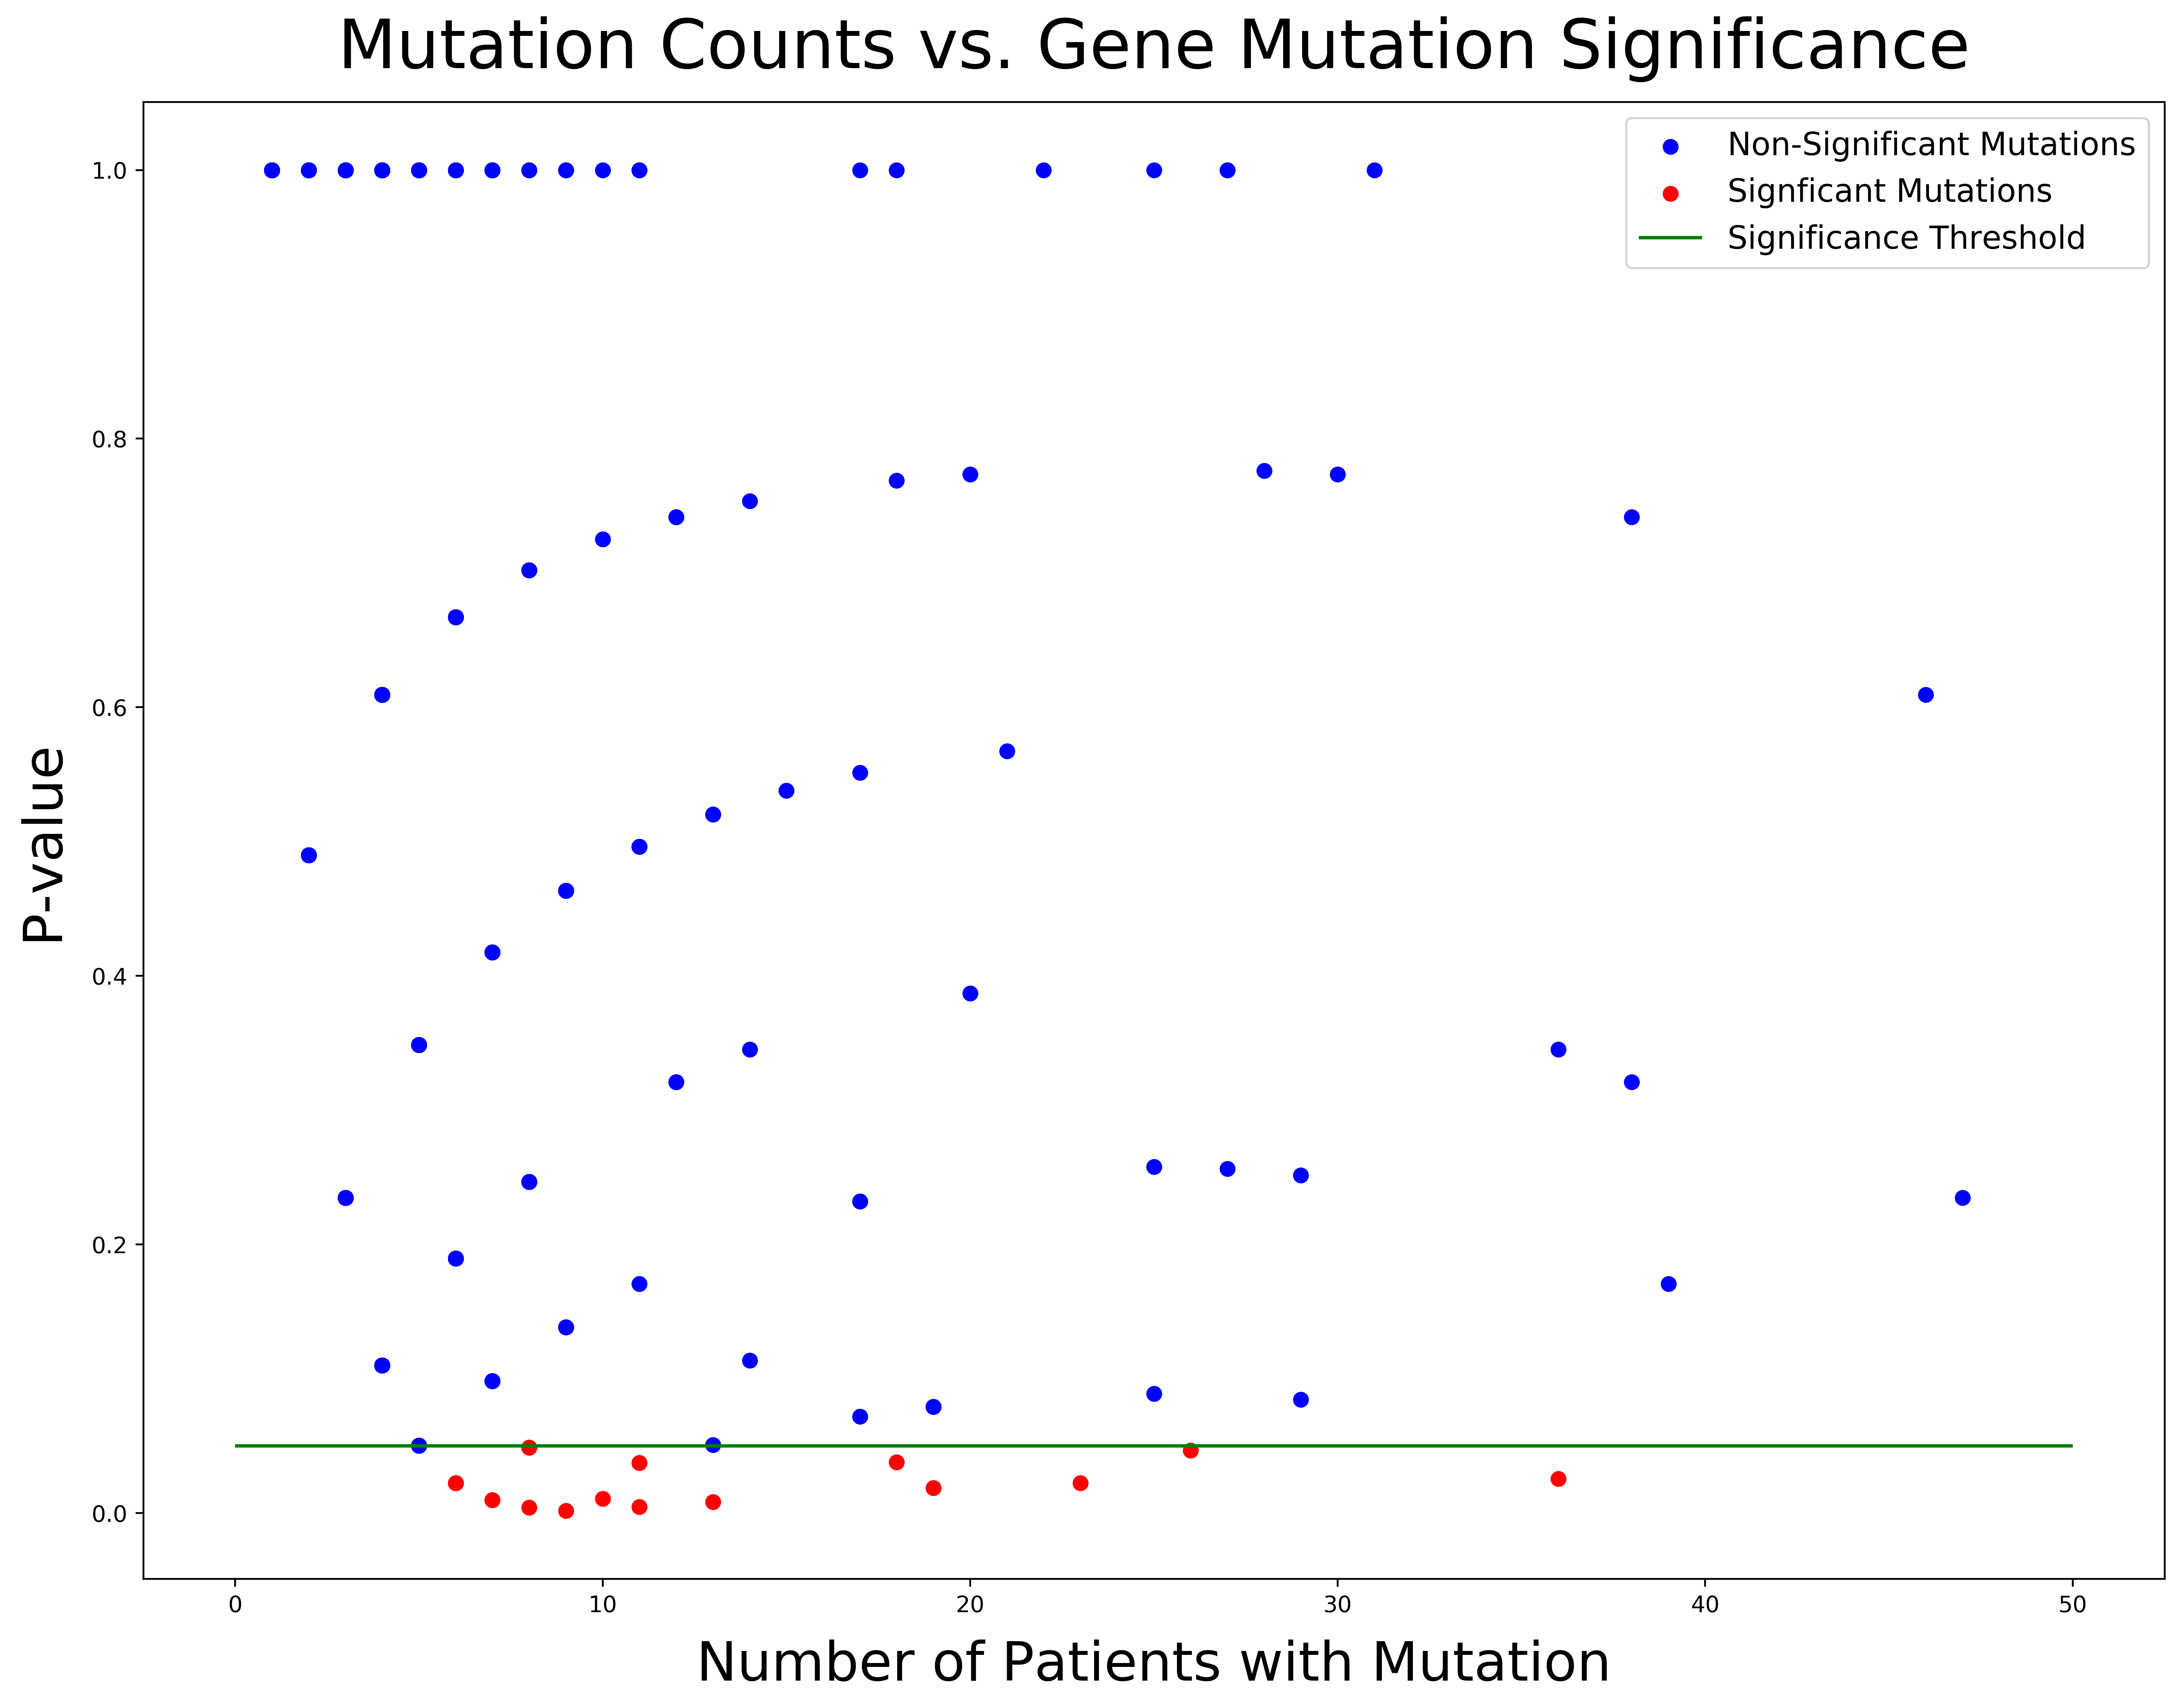

In [13]:
# make high resolution and large size figure 
plt.figure(figsize=(16,12),dpi=500)
# add title with pad 
plt.title("Mutation Counts vs. Gene Mutation Significance", fontsize=30, pad=15)
# set x-axis 
plt.xlabel("Number of Patients with Mutation", fontsize=24, labelpad=10)
# set y-axis 
plt.ylabel("P-value", fontsize=24, labelpad=10)

# plot scatter plot of non-significant genes 
plt.scatter(num_mutations_non_sig,non_sig_p_values, color="blue", label="Non-Significant Mutations")

# plot scatter plot of significant genes 
plt.scatter(num_mutations_sig, sig_p_values, color="red", label="Signficant Mutations")

# add y-line to significance point (y=0.05) 
plt.hlines(0.05, 0, 50, label="Significance Threshold", color="green")

# get legend 
plt.legend(fontsize=14)

# show final plot 
plt.show()


<h3>Significant Mutations Table</h3>

In [14]:
# list for input to matplotlib table 
sig_table = [] 

# for each significant gene 
for i in range(0,len(sig_gene_names)):
    # append row of gene name and associated two tail p-value 
    sig_table.append([sig_gene_names[i],sig_p_values[i]])

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


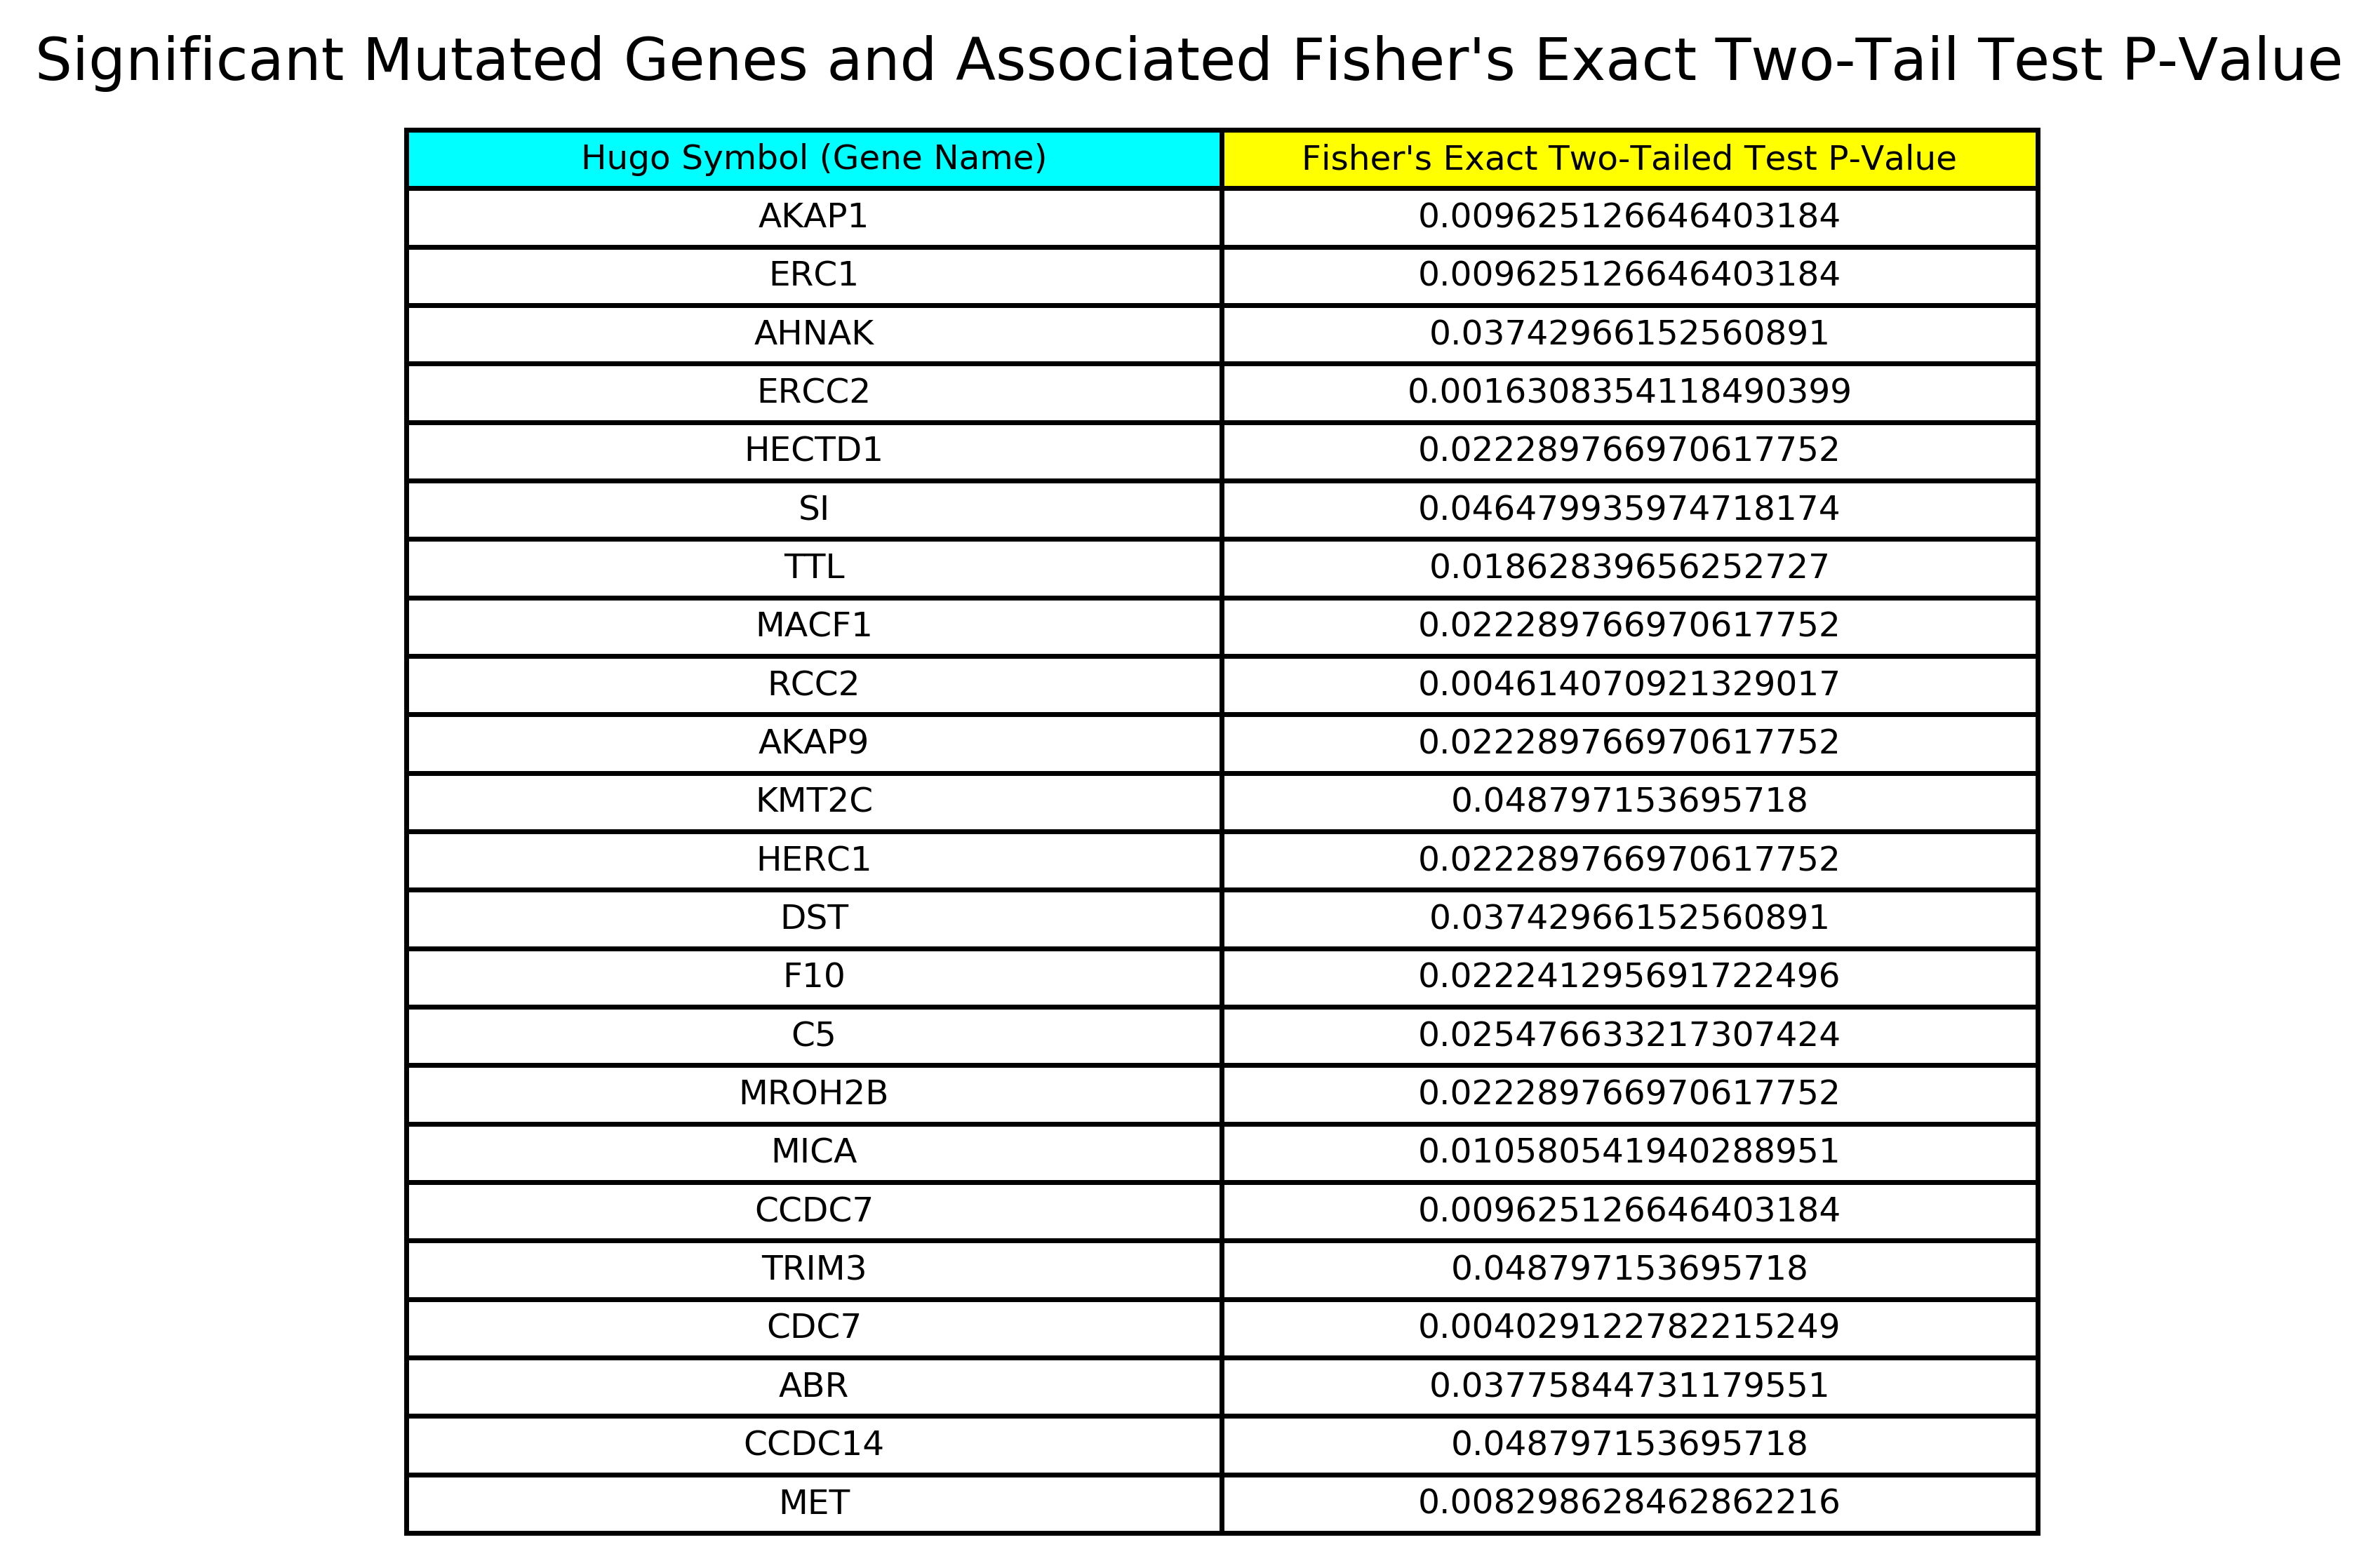

In [15]:
# set figure size and dpi 
table=plt.figure(dpi=500)
plt.title("Significant Mutated Genes and Associated Fisher's Exact Two-Tail Test P-Value")
# add subplot axis 
ax = table.add_subplot(1,1,1)

# create matplotlib table 
plt.table(cellText=sig_table, loc="upper left", cellLoc="center", 
          colLabels=["Hugo Symbol (Gene Name)","Fisher's Exact Two-Tailed Test P-Value"], 
          colColours=["aqua","yellow"])

# "turn off" axis 
ax.axis("off") 
# show table 
table.show()

<h3>Nonsynonymous Mutations per MegaBase (MB) in Samples with Most Statistically Significant Mutation vs Samples without Mutation</h3>

**Table of Samples Containing Most Significant Mutation**

In [16]:
# get most significant mutation 
most_significant_mutation = min(sig_genes, key=sig_genes.get)
most_significant_mutation

'ERCC2'

In [17]:
# get list of values for most significant mutation 
ERCC2_values = contingency_tables[most_significant_mutation]

# get number of patients with mutation 
mutated = ERCC2_values[0] + ERCC2_values[2]
# get number of patients without mutation 
not_mutated = ERCC2_values[1] + ERCC2_values[3] 
print(mutated) 
print(not_mutated)

9
41


/usr/local/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


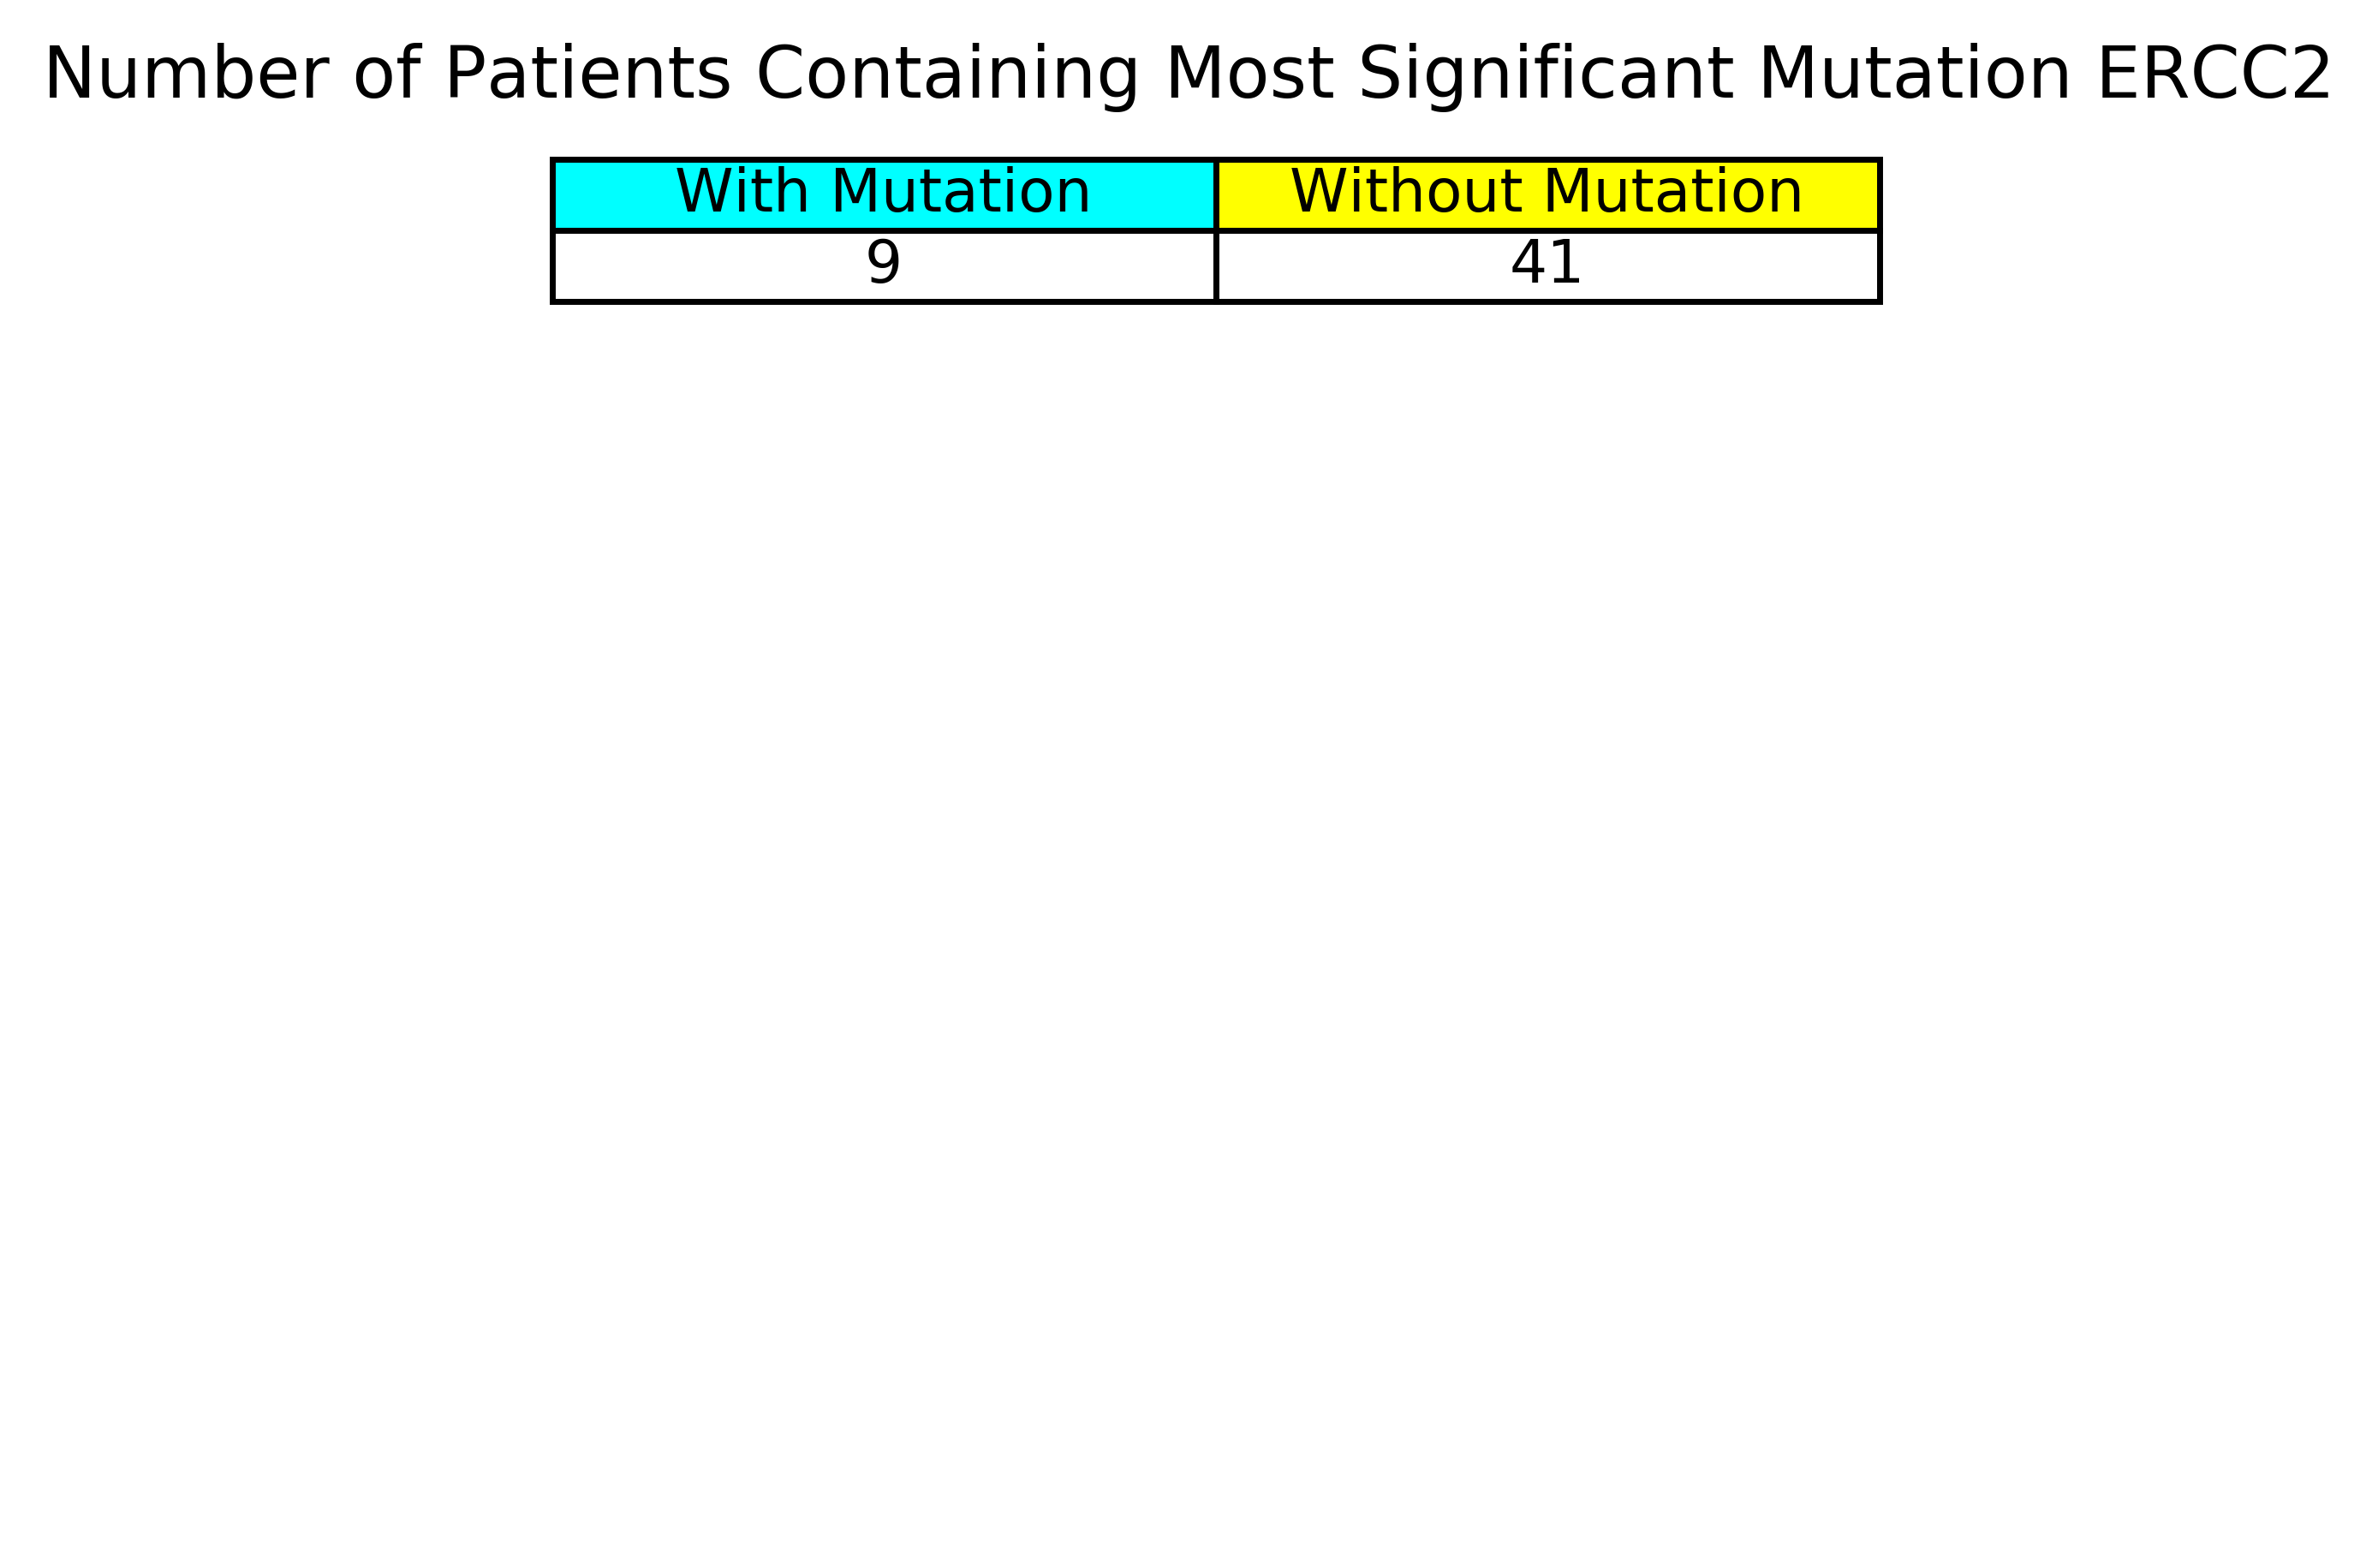

In [18]:
# set figure size and dpi 
table=plt.figure(dpi=500, figsize=(4,4))
plt.title("Number of Patients Containing Most Significant Mutation ERCC2")
# add subplot axis 
ax = table.add_subplot(1,1,1)

# create matplotlib table 
plt.table(cellText=[[mutated, not_mutated]], loc="upper left", cellLoc="center", 
          colLabels=["With Mutation","Without Mutation"], colColours=["aqua","yellow"])

# "turn off" axis 
ax.axis("off") 
# show table 
table.show()

**Prepare Data Structures for Input to Plot** 

In [19]:
# list to add to patient metadata dataframe for whether patient has ERCC2 mutation 
has_ERCC2 = []

# for each dataframe 
for i in range(0,50): 
    # check if ERCC2 in data frame 
    if "ERCC2" in not_silent["Patient-"+str(i)]["Hugo_Symbol"].tolist(): 
        has_ERCC2.append(True) 
    else: 
        has_ERCC2.append(False)


In [20]:
# append list as new column to patient metadata table 
patient_metadata["Has_ERCC2"] = has_ERCC2
patient_metadata.head()

,Tumor_Sample_Barcode,Matched_Norm_Sample_Barcode,Response,Silent_mutations_per_Mb,Nonsynonymous_mutations_per_Mb,Mutations_per_Mb,Has_ERCC2
Patient_ID,,,,,,,
Patient-0,Patient-0-Tumor,Patient-0-Normal,Non-Responder,2.87,6.77,9.64,False
Patient-1,Patient-1-Tumor,Patient-1-Normal,Responder,1.92,6.14,8.06,False
Patient-2,Patient-2-Tumor,Patient-2-Normal,Responder,1.32,2.84,4.16,False
Patient-3,Patient-3-Tumor,Patient-3-Normal,Non-Responder,1.78,5.00,6.78,False
Patient-4,Patient-4-Tumor,Patient-4-Normal,Responder,4.93,10.50,15.43,True


**Make Horizontal Bar Plot** 

In [24]:
# adjust figure size and resolution 
plt.figure(dpi=700, figsize=(20,20))

# plot horizontal bar plot with only patients that have ERCC2 mutation 
plt.barh(patient_metadata[patient_metadata["Has_ERCC2"]==True].index.tolist(), 
        patient_metadata[patient_metadata["Has_ERCC2"]==True]["Nonsynonymous_mutations_per_Mb"].tolist(), 
        label="Have Mutation", color="red")

# plot horizontal bar plot with only patients that DON'T have ERCC2 mutation 
plt.barh(patient_metadata[patient_metadata["Has_ERCC2"]==False].index.tolist(), 
        patient_metadata[patient_metadata["Has_ERCC2"]==False]["Nonsynonymous_mutations_per_Mb"].tolist(), 
        label="No Mutation", color="blue")

# set title of plot 
plt.title("Nonsynonymous Mutations per MegaBase (MB) Values per Patient", fontsize=36, pad=20)
# set x axis label 
plt.xlabel("Nonsynonymous Mutations per MegaBase (MB)", fontsize=30, labelpad=15)
# set y axis label 
plt.ylabel("Patient ID", fontsize=30, labelpad=20)
# add legend 
plt.legend()
# change xtick sizes 
plt.xticks(fontsize=24)

# show plot
plt.show()